# 🔌 Load the data and several core functions

In [36]:
import pandas as pd
import numpy as np
from pathlib import Path
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday
from pandas.tseries.offsets import CustomBusinessDay
from numba import jit
import time
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import to_rgb
from tqdm.auto import tqdm
from scipy import stats

# CONFIGURATION CENTRALISÉE
CONFIG_DATES = {
    # Paramètres de données
    'data_dir': "datasets_technicals/1d",
    'start_date': "2021-01-02", 
    'end_date': "2025-02-01"
}

class FrenchHolidayCalendar(AbstractHolidayCalendar):
    rules = [
        Holiday('New Years Day', month=1, day=1),
        Holiday('Labor Day', month=5, day=1),
        Holiday('Victory in Europe Day', month=5, day=8),
        Holiday('Bastille Day', month=7, day=14),
        Holiday('Assumption Day', month=8, day=15),
        Holiday('All Saints Day', month=11, day=1),
        Holiday('Armistice Day', month=11, day=11),
        Holiday('Christmas', month=12, day=25)
    ]

def create_trading_calendar(start: str, end: str) -> pd.DatetimeIndex:
    """Crée un calendrier de trading en excluant les jours fériés américains et français."""
    us_cal = USFederalHolidayCalendar()
    fr_cal = FrenchHolidayCalendar()
    holidays = us_cal.holidays(start, end).union(fr_cal.holidays(start, end))
    return pd.date_range(start, end, freq=CustomBusinessDay(holidays=holidays))

def load_data(config: dict, fill_limit: int = 5) -> tuple[dict, pd.DatetimeIndex]:
    """Charge les données et calcule les dates disponibles en une seule passe."""
    data = {}
    all_dates = set()
    files = list(Path(config['data_dir']).glob('*.csv'))
    
    for f in tqdm(files, desc="Chargement des données"):
        df = pd.read_csv(f, parse_dates=['Date'])
        all_dates.update(df['Date'])
        df = df.set_index('Date').sort_index()
        data[f.stem] = df
    
    start_date, end_date = min(all_dates), max(all_dates)
    trading_days = create_trading_calendar(start_date, end_date)
    
    for ticker, df in data.items():
        df = df.reindex(trading_days)
        for col in ['Close', 'Volume', 'Momentum252']:
            if col in df.columns:
                df[col] = df[col].ffill(limit=fill_limit)
        data[ticker] = df
    
    return data, trading_days


def get_color_scheme(date):
    """Générer un schéma de couleur basé sur l'année et le trimestre."""
    year = date.year
    quarter = (date.month - 1) // 3
    
    # Palette de couleurs par année
    base_colors = {
        # (Votre dictionnaire base_colors original ici)
        1980: '#2F4F4F',   # Gris-vert
        1981: '#A52A2A',   # Marron
        1982: '#FF6347',   # Tomate
        1983: '#40E0D0',   # Turquoise
        1984: '#8A2BE2',   # Bleu violet
        1985: '#5F9EA0',   # Gris-bleu
        1986: '#D2691E',   # Chocolat
        1987: '#CD5C5C',   # Rosé
        1988: '#DAA520',   # Or
        1989: '#B8860B',   # Jaune foncé
        1990: '#20B2AA',   # Vert-de-mer
        1991: '#00008B',   # Bleu marine
        1992: '#008B8B',   # Bleu-vert foncé
        1993: '#A9A9A9',   # Gris foncé
        1994: '#006400',   # Vert foncé
        1995: '#FF4500',   # Orange rougeâtre
        1996: '#2E8B57',   # Vert
        1997: '#7FFF00',   # Vert clair
        1998: '#D2691E',   # Chocolat
        1999: '#9ACD32',   # Jaune-vert
        2000: '#8B0000',   # Rouge foncé
        2001: '#B0C4DE',   # Bleu clair
        2002: '#A9A9A9',   # Gris
        2003: '#8B008B',   # Magenta foncé
        2004: '#FF8C00',   # Orange foncé
        2005: '#D3D3D3',   # Gris clair
        2006: '#C71585',   # Violet foncé
        2007: '#FF1493',   # Rose vif
        2008: '#ADFF2F',   # Vert jaunâtre
        2009: '#F0E68C',   # Jaune pâle
        2010: '#B22222',   # Rouge brique
        2011: '#FFD700',   # Or
        2012: '#1f77b4',   # Bleu
        2013: '#2ca02c',   # Vert
        2014: '#ff7f0e',   # Orange
        2015: '#d62728',   # Rouge
        2016: '#9467bd',   # Violet
        2017: '#8c564b',   # Marron
        2018: '#e377c2',   # Rose
        2019: '#7f7f7f',   # Gris
        2020: '#bcbd22',   # Jaune-vert
        2021: '#17becf',   # Cyan
        2022: '#1a55FF',   # Bleu royal
        2023: '#FF1a1a',   # Rouge vif
        2024: '#B0E0E6',   # Bleu pâle
        2025: '#4682B4',   # Bleu acier
        2026: '#D2691E',   # Chocolat
        2027: '#FF6347',   # Tomate
        2028: '#A52A2A',   # Marron
        2029: '#8B4513',   # Sienne brune
        2030: '#2F4F4F'    # Gris-vert
    }
    
    # Ajustement de la luminosité selon le trimestre
    brightness_factor = 0.6 + (quarter * 0.1)  # 0.6, 0.7, 0.8, 0.9
    
    base_color = np.array(to_rgb(base_colors.get(year, '#1f77b4')))
    adjusted_color = base_color * brightness_factor
    adjusted_color = np.clip(adjusted_color, 0, 1)
    
    return adjusted_color

def evaluate_metrics(metrics):
    thresholds = {
        'Annual Return': {
            'good': 15, 'medium': 8, 'neutral': 3,
            'explain': {
                'good': 'Plus de 15% de rendement annuel',
                'medium': 'Entre 8% et 15% de rendement annuel',
                'neutral': 'Entre 3% et 8% de rendement annuel',
                'bad': 'Moins de 3% de rendement annuel'
            },
            'format': '.2f%'
        },
        'Sharpe': {
            'good': 1.0, 'medium': 0.5, 'neutral': 0.2,
            'explain': {
                'good': 'Plus de 1.0 : Excellent ratio rendement/risque',
                'medium': 'Entre 0.5 et 1.0 : Bon compromis',
                'neutral': 'Entre 0.2 et 0.5 : Risque élevé',
                'bad': 'Moins de 0.2 : Risque excessif'
            },
            'format': '.3f'
        },
        'Profit Factor': {
            'good': 2.0, 'medium': 1.5, 'neutral': 1.2,
            'explain': {
                'good': 'Plus de 200% de gains vs pertes',
                'medium': 'Entre 150% et 200% de gains vs pertes',
                'neutral': 'Entre 120% et 150% de gains vs pertes',
                'bad': 'Moins de 120% de gains vs pertes'
            },
            'format': '.3f'
        },
        'Sortino': {
            'good': 2.0, 'medium': 1.0, 'neutral': 0.5,
            'explain': {
                'good': 'Au-dessus de 2.0 : Excellent contrôle du risque',
                'medium': 'Entre 1.0 et 2.0 : Bon contrôle',
                'neutral': 'Entre 0.5 et 1.0 : Contrôle limité',
                'bad': 'Sous 0.5 : Risque mal maîtrisé'
            },
            'format': '.3f'
        },
        'Expectancy': {
            'good': 0.01, 'medium': 0.001, 'neutral': 0.0001,
            'explain': {
                'good': 'Plus de 1% de gain moyen par trade',
                'medium': 'Entre 0.1% et 1% par trade',
                'neutral': 'Entre 0.01% et 0.1% par trade',
                'bad': 'Moins de 0.01% par trade'
            },
            'format': '.5f'
        }
    }
    
    # ANSI color codes
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    BLUE = '\033[94m'
    RED = '\033[91m'
    GRAY = '\033[90m'
    BOLD = '\033[1m'
    END = '\033[0m'
    
    pros = []
    neutral = []
    cons = []
    
    def get_category_and_color(name, value):
        if value >= thresholds[name]['good']:
            return 'good', GREEN
        elif value >= thresholds[name]['medium']:
            return 'medium', YELLOW
        elif value >= thresholds[name]['neutral']:
            return 'neutral', BLUE
        return 'bad', RED
    
    # Évaluation des métriques
    for name, value in metrics.items():
        if name in thresholds:
            category, color = get_category_and_color(name, value)
            if thresholds[name]['format'].endswith('%'):
                formatted_value = f"{value:.2f}%"
            else:
                formatted_value = f"{value:.3f}"
            metric_info = f"{name}: {color}{formatted_value}{END}"
            explanation = f"{GRAY}{thresholds[name]['explain'][category]}{END}"
            
            if category in ['good', 'medium']:
                pros.append((metric_info, explanation))
            elif category == 'neutral':
                neutral.append((metric_info, explanation))
            else:
                cons.append((metric_info, explanation))
    
    # Affichage
    print(f"\n\n\n\n{BOLD}🎯 Performance Analysis{END}")
    print("=" * 70)
    
    print(f"\n{GREEN}✨ PROS{END}")
    print("-" * 70)
    if pros:
        for metric, explain in pros:
            print(f"🟢 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print(f"\n{BLUE}⚖️ NEUTRAL{END}")
    print("-" * 70)
    if neutral:
        for metric, explain in neutral:
            print(f"🔷 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print(f"\n{RED}⚠️ CONS{END}")
    print("-" * 70)
    if cons:
        for metric, explain in cons:
            print(f"🔴 {metric}")
            print(f"   {explain}")
    else:
        print("None found")
    
    print("\n" + "=" * 70)


data, trading_days = load_data(CONFIG_DATES)

Chargement des données:   0%|          | 0/1274 [00:00<?, ?it/s]

# 🦑 Backtest engine
###### 
###### Voici les améliorations potentielles majeures :
###### 
###### Gestion du risque
###### 
###### 
###### Allocation dynamique du capital basée sur la volatilité
###### Position sizing adaptatif selon ATR
###### Corrélation entre positions pour diversification optimale
###### Time-stop pour sortir des positions stagnantes
###### 
###### 
###### Sélection des titres
###### 
###### 
###### Combiner plusieurs timeframes de momentum (21j, 63j, 252j)
###### Ajouter filtres de tendance (ex: MM200)
###### Indicateurs de volatilité (ATR, Bollinger)
###### Score composite multi-facteurs
###### 
###### 
###### Market timing
###### 
###### 
###### Filtre de tendance globale de marché
###### Indicateur de regime de volatilité
###### Exposition variable selon conditions macro
###### 
###### 
###### Exécution
###### 
###### 
###### Entrées échelonnées
###### Sorties partielles sur objectifs
###### Heures d'entrée/sortie optimales
###### Gestion des gaps

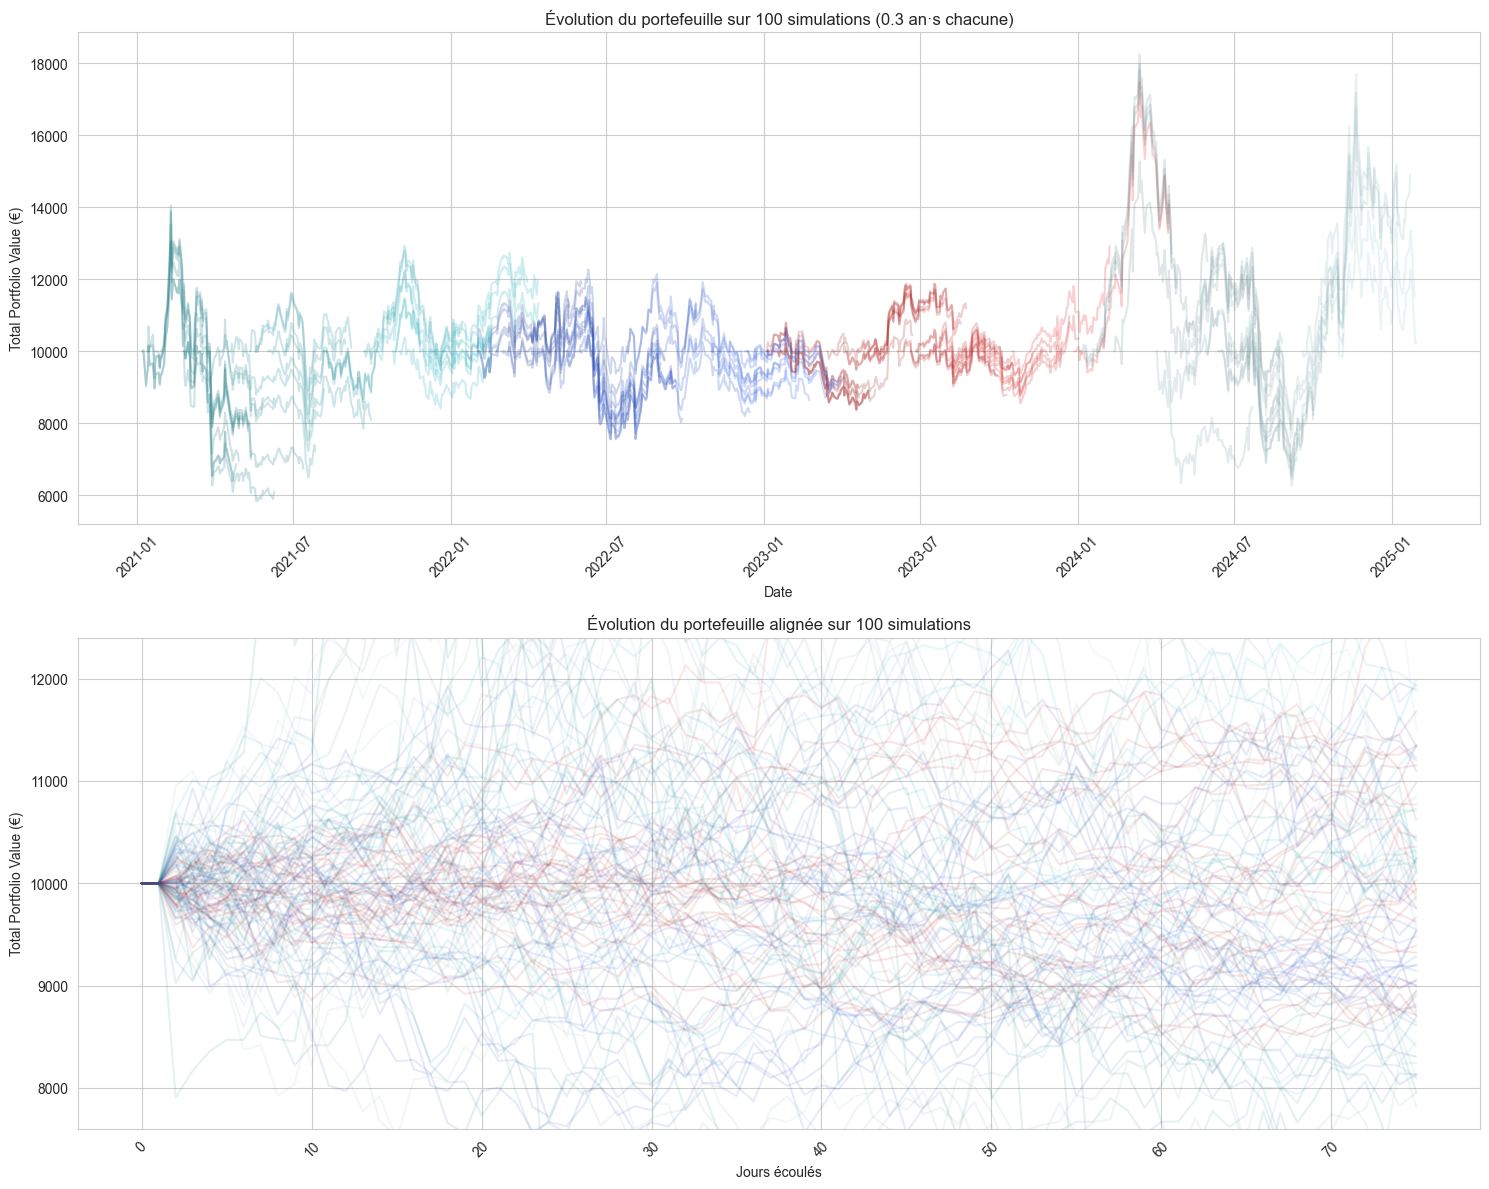

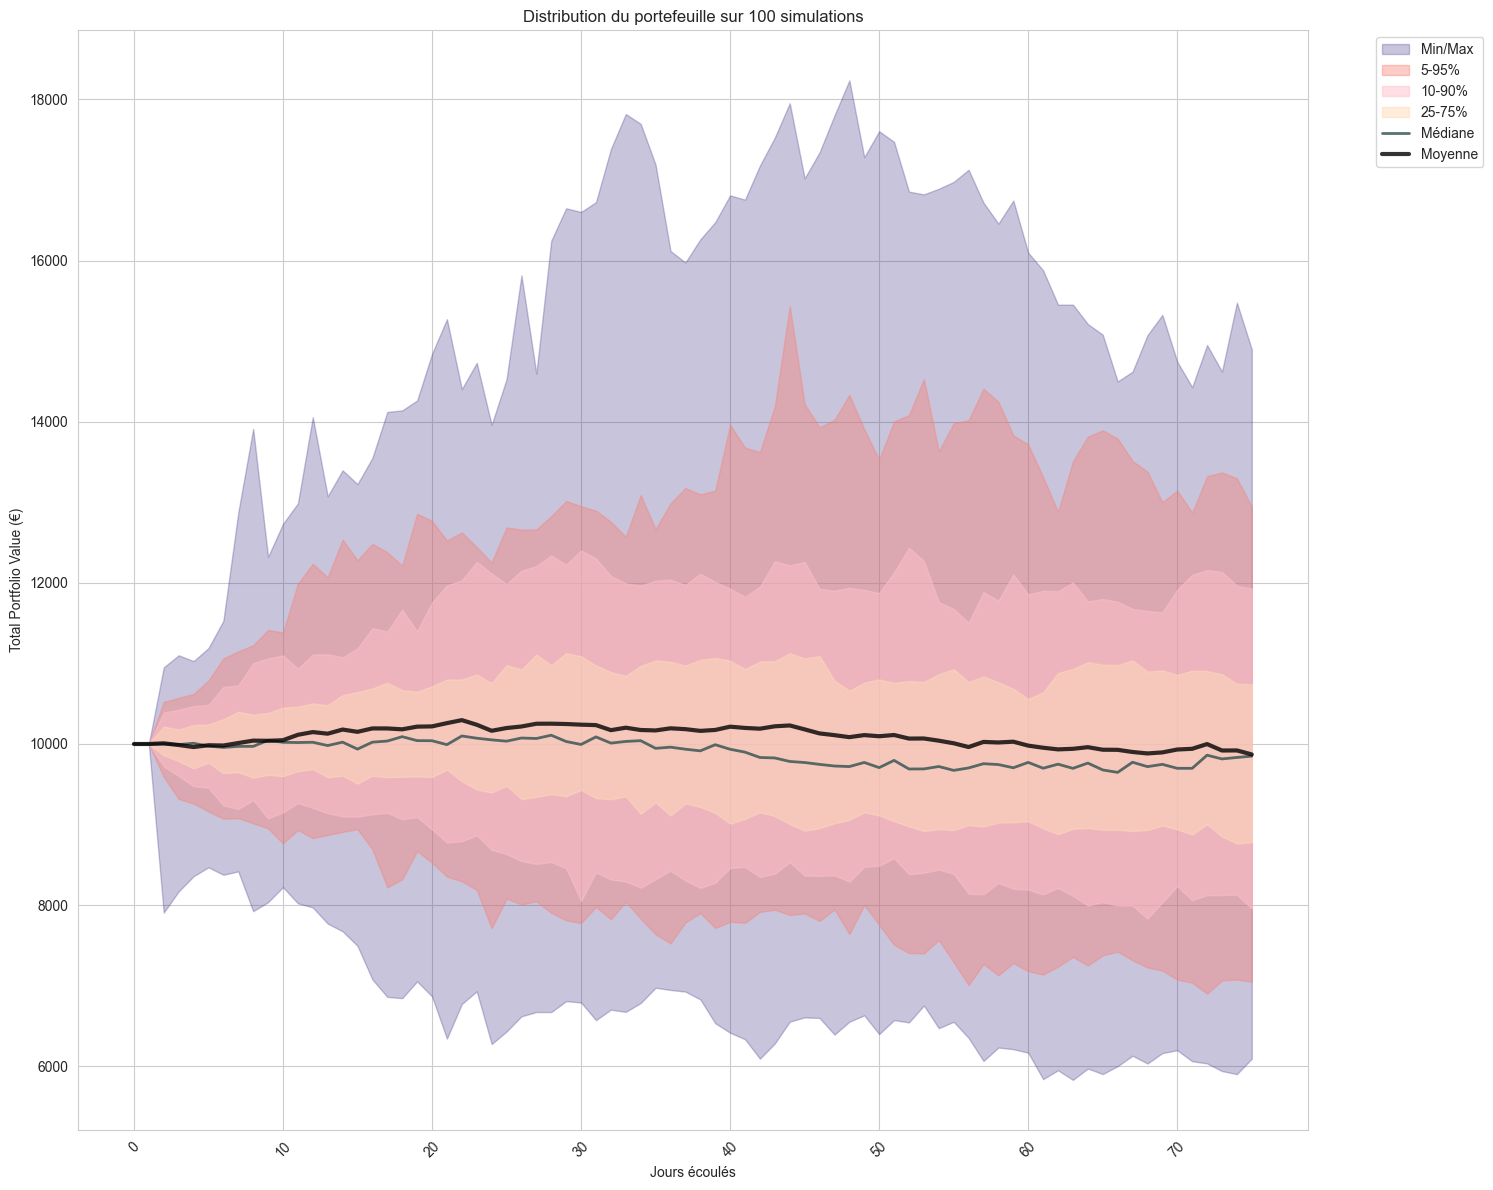

🤑 Total Return: -1.30%
🧧 Annual Return: -4.32%
📉 Avg annual Return: -4.26%
📉 Avg daily Return: -0.02%
📈 Avg Volatility: 0.32%
🎈 Sharpe ratio: -0.053
🎯 Sortino: -0.083
💰 Profit Factor: 0.876
💫 Expectancy: -0.000

⏰ Temps total d'exécution: 21.77 secondes




🎯 Performance Analysis

✨ PROS
----------------------------------------------------------------------
None found

⚖️ NEUTRAL
----------------------------------------------------------------------
None found

⚠️ CONS
----------------------------------------------------------------------
🔴 Annual Return: -4.32%
   Moins de 3% de rendement annuel
🔴 Sharpe: -0.053
   Moins de 0.2 : Risque excessif
🔴 Profit Factor: 0.876
   Moins de 120% de gains vs pertes
🔴 Sortino: -0.083
   Sous 0.5 : Risque mal maîtrisé
🔴 Expectancy: -0.000
   Moins de 0.01% par trade



In [ ]:
CONFIG_TRADES = {
    
    'start_date': CONFIG_DATES['start_date'],  # Réutilisation du paramètre
    'end_date': CONFIG_DATES['end_date'],      # Réutilisation du paramètre
    
    # Paramètres de simulation
    'simulation_years': 0.3,  # 6 mois
    'n_simulations': 100,
    'trailing_stop_pct' : 0.3,
    
    
    # Paramètres de portefeuille
    'initial_cash': 10000,
    'position_size': 2500,
    'fee_rate': 0.0025,
    
    # Paramètres de sélection
    'top_n': 4,  # Nombre de stocks à sélectionner
    'volume_percentile': 75.0,  # Filtrage par volume
    
    # Autres paramètres
    'random_seed': 1  # None pour un seed aléatoire
}


@jit(nopython=True)
def calculate_position_changes(prev_holdings, top_10_mask, close_prices, entry_prices, high_prices_since_entry, cash, position_size, fee_rate, trailing_stop_pct):
    """Calcule les changements de positions avec trailing stop-loss."""
    new_holdings = prev_holdings.copy()
    new_entry_prices = entry_prices.copy()
    new_high_prices = high_prices_since_entry.copy()
    total_fees = 0.0

    # Mise à jour des plus hauts historiques
    active_positions = prev_holdings > 0
    new_high_prices[active_positions] = np.maximum(
        high_prices_since_entry[active_positions],
        close_prices[active_positions]
    )

    # Calcul du trailing stop
    trailing_stop_triggered = np.where(new_high_prices > 0, 
                                     close_prices / new_high_prices < (1 - trailing_stop_pct), 
                                     False)
    
    # Masque combiné pour toutes les conditions de vente
    sell_mask = active_positions & (trailing_stop_triggered | ~top_10_mask)
    
    # Calcul vectorisé des ventes
    sale_values = prev_holdings * close_prices * sell_mask
    total_sale_value = np.sum(sale_values)
    cash += total_sale_value * (1 - fee_rate)
    total_fees += total_sale_value * fee_rate
    
    # Mise à zéro des positions vendues
    new_holdings[sell_mask] = 0.0
    new_entry_prices[sell_mask] = 0.0
    new_high_prices[sell_mask] = 0.0

    # Acheter les nouvelles positions
    buy_candidates = np.where(top_10_mask & (new_holdings == 0))[0]
    for i in buy_candidates:
        if cash >= position_size:
            shares = position_size / close_prices[i]
            cash -= position_size
            total_fees += position_size * fee_rate
            new_holdings[i] = shares
            new_entry_prices[i] = close_prices[i]
            new_high_prices[i] = close_prices[i]

    return new_holdings, new_entry_prices, new_high_prices, cash, total_fees


def optimized_backtest(data: dict, trading_days: pd.DatetimeIndex, config: dict):
    """Exécute le backtest avec trailing stop-loss."""
    filtered_data = {
        ticker: df for ticker, df in data.items() 
        if 'Momentum252' in df.columns
    }
    
    close = pd.DataFrame({ticker: df['Close'] for ticker, df in filtered_data.items()})
    volume = pd.DataFrame({ticker: df['Volume'] for ticker, df in filtered_data.items()})
    momentum = pd.DataFrame({ticker: df['Momentum252'] for ticker, df in filtered_data.items()})
    
    close = close.reindex(trading_days)
    volume = volume.reindex(trading_days)
    momentum = momentum.reindex(trading_days)

    holdings = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    entry_prices = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    high_prices = pd.DataFrame(0.0, index=trading_days, columns=close.columns)
    
    portfolio = pd.DataFrame({
        'cash': config['initial_cash'],
        'fees': 0.0,
        'portfolio_value': float(config['initial_cash'])
    }, index=trading_days, dtype=float)

    for i in range(1, len(trading_days)):
        date = trading_days[i]
        prev_date = trading_days[i - 1]

        day_close = close.loc[date]
        
        # Mise à jour des positions
        na_mask = day_close.isna()
        valid_data = ~np.isnan(momentum.loc[date]) & ~np.isnan(volume.loc[date]) & ~na_mask
        
        if valid_data.sum() > 0:
            vol_threshold = np.nanpercentile(volume.loc[date][valid_data], config['volume_percentile'])
        else:
            vol_threshold = 0
            
        volume_filter = (volume.loc[date] >= vol_threshold) & valid_data
        mom_rank = momentum.loc[date][volume_filter].rank(ascending=False)
        top_selection = pd.Series(False, index=close.columns)
        top_selection[mom_rank[mom_rank <= config['top_n']].index] = True
        top_selection[na_mask] = False

        new_holdings, new_entry_prices, new_high_prices, new_cash, fees = calculate_position_changes(
            holdings.loc[prev_date].values,
            top_selection.values,
            day_close.fillna(0).values,
            entry_prices.loc[prev_date].values,
            high_prices.loc[prev_date].values,
            portfolio.loc[prev_date, 'cash'],
            config['position_size'],
            config['fee_rate'],
            config['trailing_stop_pct']
        )

        holdings.loc[date] = new_holdings
        entry_prices.loc[date] = new_entry_prices
        high_prices.loc[date] = new_high_prices
        holdings_value = (holdings.loc[date] * day_close.fillna(0)).sum()
        portfolio.loc[date, 'cash'] = float(new_cash)
        portfolio.loc[date, 'fees'] = portfolio.loc[prev_date, 'fees'] + fees
        portfolio.loc[date, 'portfolio_value'] = float(new_cash + holdings_value)

    return portfolio, holdings, entry_prices

def run_multiple_simulations(config: dict):
    """Lance plusieurs simulations de backtest."""
    # Charger les données
    
    # Création du calendrier de trading
    trading_days = create_trading_calendar(config['start_date'], config['end_date'])
    
    # Sélection de n dates de départ aléatoires
    DAYS_IN_YEAR = 252
    np.random.seed(config['random_seed'])
    start_indices = np.random.choice(
        len(trading_days) - int(config['simulation_years'] * DAYS_IN_YEAR), 
        config['n_simulations'], 
        replace=False
    )
    start_dates = [trading_days[i] for i in start_indices]
    
    # Stocker les résultats des simulations
    simulations = {}
    
    for i, start_date in enumerate(start_dates):
        # Définir la période de la simulation
        end_date = trading_days[start_indices[i] + int(config['simulation_years'] * DAYS_IN_YEAR)]
        
        # Filtrer les jours de trading correspondants
        sim_trading_days = trading_days[(trading_days >= start_date) & (trading_days <= end_date)]
        
        # Exécuter le backtest
        portfolio, _, _ = optimized_backtest(data, sim_trading_days, config)  # Modifié ici
        
        # Stocker la valeur totale du portefeuille
        simulations[f"Sim {i+1}"] = portfolio['portfolio_value']
    
    return simulations

# Lancer les simulations
start_time = time.time()

# Simulations avec la configuration centralisée
simulations = run_multiple_simulations(CONFIG_TRADES)

# Stocker les résultats avec un index commun basé sur le nombre de jours écoulés
aligned_simulations = {}
for i, (label, values) in enumerate(simulations.items()):
    days_elapsed = np.arange(len(values))
    aligned_simulations[label] = pd.Series(values.values, index=days_elapsed)

# Créer le DataFrame aligné
df_aligned = pd.DataFrame(aligned_simulations)

# Graphiques (code de visualisation identique à votre version originale)
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

# Premier graphique : simulations avec dates réelles
plt.subplot(2, 1, 1)
for label, values in simulations.items():
    start_date = values.index[0]
    color = get_color_scheme(start_date)
    year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
    plt.plot(values.index, values, label=f"{label} ({year_quarter})", 
             color=color, alpha=0.2)

plt.title(f"Évolution du portefeuille sur {CONFIG_TRADES['n_simulations']} simulations ({CONFIG_TRADES['simulation_years']} an·s chacune)")
plt.xlabel("Date")
plt.ylabel("Total Portfolio Value (€)")
plt.xticks(rotation=45)

# Deuxième graphique : simulations avec jours alignés
plt.subplot(2, 1, 2)
for label, values in aligned_simulations.items():
    start_date = simulations[label].index[0]
    color = get_color_scheme(start_date)
    year_quarter = f"{start_date.year}-Q{(start_date.month-1)//3 + 1}"
    plt.plot(values.index, values, label=f"{label} ({year_quarter})", 
             color=color, alpha=0.1)

plt.title(f"Évolution du portefeuille alignée sur {CONFIG_TRADES['n_simulations']} simulations")
plt.xlabel("Jours écoulés")
plt.ylabel("Total Portfolio Value (€)")
plt.ylim(
        CONFIG_TRADES['initial_cash']*(1-(0.8*CONFIG_TRADES['simulation_years'])),
        CONFIG_TRADES['initial_cash']*(1+(0.8*CONFIG_TRADES['simulation_years']))
        )
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Graphique des statistiques de distribution
plt.figure(figsize=(15, 12))
sns.set_style("whitegrid")

# Calcul des statistiques
mean_values = df_aligned.mean(axis=1)
min_values = df_aligned.min(axis=1)
max_values = df_aligned.max(axis=1)
p5_values = df_aligned.quantile(0.05, axis=1)
p10_values = df_aligned.quantile(0.10, axis=1)
p25_values = df_aligned.quantile(0.25, axis=1)
p50_values = df_aligned.quantile(0.50, axis=1)
p75_values = df_aligned.quantile(0.75, axis=1)
p90_values = df_aligned.quantile(0.90, axis=1)
p95_values = df_aligned.quantile(0.95, axis=1)

# Canal valeurs extrêmes (min et max)
plt.fill_between(min_values.index, min_values, max_values, 
                 color='DarkSlateBlue', alpha=0.3, label="Min/Max")

# Canal 5% - 95%
plt.fill_between(p5_values.index, p5_values, p95_values, 
                 color='Salmon', alpha=0.4, label="5-95%")

# Canal 10% - 90%
plt.fill_between(p10_values.index, p10_values, p90_values, 
                 color='Pink', alpha=0.5, label="10-90%")

# Canal quartiles (Q1 et Q3)
plt.fill_between(p25_values.index, p25_values, p75_values, 
                 color='PeachPuff', alpha=0.5, label="25-75%")

# Médiane
plt.plot(p50_values.index, p50_values.values, 
        label="Médiane", 
        color='DarkSlateGray', linewidth=2, alpha=0.8)

# Moyenne
plt.plot(mean_values.index, mean_values.values, 
        label="Moyenne",
        color='black', linewidth=3, alpha=0.8)

plt.title(f"Distribution du portefeuille sur {CONFIG_TRADES['n_simulations']} simulations")
plt.xlabel("Jours écoulés")
plt.ylabel("Total Portfolio Value (€)")
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Calcul des métriques existantes
final_return = float(mean_values.iloc[-1]/mean_values.iloc[0]-1)
annual_return = final_return/CONFIG_TRADES['simulation_years']
daily_returns = mean_values.pct_change()
avg_return = daily_returns.mean()
volat = daily_returns.std()
sharpe = avg_return/volat

# Nouveaux indicateurs
# Profit Factor
daily_gains = daily_returns[daily_returns > 0].sum()
daily_losses = abs(daily_returns[daily_returns < 0].sum())
profit_factor = daily_gains / daily_losses if daily_losses != 0 else float('inf')

# Sortino Ratio (utilise les rendements négatifs uniquement pour la volatilité)
downside_returns = daily_returns[daily_returns < 0]
downside_std = downside_returns.std()
sortino = avg_return/downside_std if downside_std != 0 else float('inf')

# Expectancy
avg_gain = daily_returns[daily_returns > 0].mean()
avg_loss = daily_returns[daily_returns < 0].mean()
win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns)
expectancy = (win_rate * avg_gain) - ((1 - win_rate) * abs(avg_loss))


print(f'🤑 Total Return: {100*final_return:.2f}%')
if CONFIG_TRADES['simulation_years']!=1:
    print(f'🧧 Annual Return: {100*annual_return:.2f}%')
print(f'📉 Avg annual Return: {252*100*avg_return:.2f}%')
print(f'📉 Avg daily Return: {100*avg_return:.2f}%')
print(f'📈 Avg Volatility: {100*volat:.2f}%')
print(f'🎈 Sharpe ratio: {sharpe:.3f}')
print(f'🎯 Sortino: {sortino:.3f}')
print(f'💰 Profit Factor: {profit_factor:.3f}')
print(f'💫 Expectancy: {expectancy:.3f}')



# Temps total d'exécution
print(f"\n⏰ Temps total d'exécution: {time.time() - start_time:.2f} secondes")




# Calcul des métriques
metrics = {
    'Total Return': final_return * 100,
    'Annual Return': annual_return * 100,
    'Avg Annual Return': annual_return * 100,  # Assurez-vous que cette valeur est définie
    'Avg Daily Return': avg_return * 100,    # Assurez-vous que cette valeur est définie
    'Sharpe': sharpe,
    'Profit Factor': profit_factor,
    'Sortino': sortino,
    'Expectancy': expectancy,
    'K-Ratio': k_ratio
}
evaluate_metrics(metrics)

# 💉 Hyperparameter boosting (using Optuna)

In [ ]:
import optuna

# Configuration centralisée pour Optuna
OPTUNA_CONFIG = {
    'n_trials': 100,
    'seed': 42,
    'initial_cash': 10000,
    'simulation_years': 0.5,
    'n_simulations': 25,
    'fee_rate': 0.0025
}

def objective(trial):
    # Configuration de base
    CONFIG_TRADES = {
        'start_date': CONFIG_DATES['start_date'],
        'end_date': CONFIG_DATES['end_date'],
        'simulation_years': OPTUNA_CONFIG['simulation_years'],
        'n_simulations': OPTUNA_CONFIG['n_simulations'],
        'random_seed': OPTUNA_CONFIG['seed'],
        'initial_cash': OPTUNA_CONFIG['initial_cash'],
        'fee_rate': OPTUNA_CONFIG['fee_rate']
    }
    
    # Paramètres à optimiser
    top_n = trial.suggest_int('top_n', 1, 12)
    trailing_stop_pct = trial.suggest_float('trailing_stop_pct', 0.15, 0.40)
    volume_percentile = trial.suggest_float('volume_percentile', 60, 85.0)
    
    # Calcul du position_size
    max_position_size = CONFIG_TRADES['initial_cash'] / top_n
    position_ratio = trial.suggest_float('position_ratio', 0.9, 1.0)
    position_size = int(position_ratio * max_position_size)
    
    # Mise à jour de la configuration
    CONFIG_TRADES.update({
        'position_size': position_size,
        'top_n': top_n,
        'trailing_stop_pct': trailing_stop_pct,
        'volume_percentile': volume_percentile
    })
    
    # Exécution des simulations
    simulations = run_multiple_simulations(CONFIG_TRADES)
    
    # Calcul des métriques
    aligned_simulations = {
        label: pd.Series(values.values, index=np.arange(len(values)))
        for label, values in simulations.items()
    }
    df_aligned = pd.DataFrame(aligned_simulations)
    stats = df_aligned.pct_change().agg(['mean', 'std']).iloc[:, 0]
    sharpe = stats['mean']/stats['std']
    
    return sharpe

class OptunaVisualizer:
    def __init__(self):
        self.results_df = pd.DataFrame([], columns=[
            'trial_number', 'top_n', 'trailing_stop_pct', 'volume_percentile', 
            'position_ratio', 'sharpe', 'position_size'
        ])
        # Définir les types de données explicitement
        self.dtypes = {
            'trial_number': 'int64',
            'top_n': 'int64',
            'trailing_stop_pct': 'float64',
            'volume_percentile': 'float64',
            'position_ratio': 'float64',
            'sharpe': 'float64',
            'position_size': 'int64'
        }
        self.results_df = self.results_df.astype(self.dtypes)
        
    def callback(self, study, trial):
        position_size = int(trial.params['position_ratio'] * (OPTUNA_CONFIG['initial_cash'] / trial.params['top_n']))
        
        new_result = pd.DataFrame({
            'trial_number': [trial.number],
            'top_n': [trial.params['top_n']],
            'trailing_stop_pct': [trial.params['trailing_stop_pct']],
            'volume_percentile': [trial.params['volume_percentile']],
            'position_ratio': [trial.params['position_ratio']],
            'sharpe': [trial.value],
            'position_size': [position_size]
        })
        self.results_df.loc[len(self.results_df)] = {
            'trial_number': trial.number,
            'top_n': trial.params['top_n'],
            'trailing_stop_pct': trial.params['trailing_stop_pct'],
            'volume_percentile': trial.params['volume_percentile'],
            'position_ratio': trial.params['position_ratio'],
            'sharpe': trial.value,
            'position_size': position_size
        }

    def create_3d_visualizations(self):
        fig = make_subplots(
            rows=2, cols=2,
            specs=[[{'type': 'scene'}, {'type': 'scene'}],
                  [{'type': 'scene'}, {'type': 'scene'}]],
            subplot_titles=(
                'Vue 1: Stop Loss vs Top N',
                'Vue 2: Stop Loss vs Volume',
                'Vue 3: Top N vs Volume',
                'Vue 4: Performance temporelle'
            )
        )
        
        # Vue 1: Stop Loss vs Top N
        fig.add_trace(
            go.Scatter3d(
                x=self.results_df['trailing_stop_pct'],
                y=self.results_df['top_n'],
                z=self.results_df['volume_percentile'],
                mode='markers',
                marker=dict(
                    size=8,
                    color=self.results_df['sharpe'],
                    colorscale='Viridis',
                    opacity=0.8,
                    colorbar=dict(title='Sharpe Ratio')
                ),
                text=[f'Sharpe: {s:.3f}' for s in self.results_df['sharpe']],
                hoverinfo='text'
            ),
            row=1, col=1
        )
        
        # Vue 2: Stop Loss vs Volume
        fig.add_trace(
            go.Scatter3d(
                x=self.results_df['trailing_stop_pct'],
                y=self.results_df['volume_percentile'],
                z=self.results_df['top_n'],
                mode='markers',
                marker=dict(
                    size=8,
                    color=self.results_df['sharpe'],
                    colorscale='Viridis',
                    opacity=0.8
                ),
                text=[f'Sharpe: {s:.3f}' for s in self.results_df['sharpe']],
                hoverinfo='text'
            ),
            row=1, col=2
        )
        
        # Vue 3: Top N vs Volume
        fig.add_trace(
            go.Scatter3d(
                x=self.results_df['top_n'],
                y=self.results_df['volume_percentile'],
                z=self.results_df['trailing_stop_pct'],
                mode='markers',
                marker=dict(
                    size=8,
                    color=self.results_df['sharpe'],
                    colorscale='Viridis',
                    opacity=0.8
                ),
                text=[f'Sharpe: {s:.3f}' for s in self.results_df['sharpe']],
                hoverinfo='text'
            ),
            row=2, col=1
        )
        
        # Vue 4: Performance temporelle
        fig.add_trace(
            go.Scatter3d(
                x=self.results_df['trial_number'],
                y=self.results_df['sharpe'],
                z=self.results_df['trailing_stop_pct'],
                mode='markers+lines',
                marker=dict(
                    size=6,
                    color=self.results_df['sharpe'],
                    colorscale='Viridis',
                    opacity=0.8
                )
            ),
            row=2, col=2
        )
        
        # Mise à jour du layout
        fig.update_layout(
            title='Analyse 3D des résultats d\'optimisation',
            showlegend=False,
            width=1200,
            height=1000
        )
        
        # Configuration des axes pour chaque vue
        scene_configs = [
            dict(
                xaxis_title='Stop Loss',
                yaxis_title='Top N',
                zaxis_title='Volume Percentile',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            ),
            dict(
                xaxis_title='Stop Loss',
                yaxis_title='Volume Percentile',
                zaxis_title='Top N',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            ),
            dict(
                xaxis_title='Top N',
                yaxis_title='Volume Percentile',
                zaxis_title='Stop Loss',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            ),
            dict(
                xaxis_title='Trial',
                yaxis_title='Sharpe',
                zaxis_title='Stop Loss',
                camera=dict(eye=dict(x=1.5, y=1.5, z=1.5))
            )
        ]
        
        for i, scene_config in enumerate(scene_configs):
            fig.update_scenes(
                scene_config,
                row=(i // 2) + 1,
                col=(i % 2) + 1
            )
        
        return fig

def run_optimization_with_tracking():
    """
    Fonction principale d'optimisation qui utilise la configuration centralisée
    """
    visualizer = OptunaVisualizer()
    
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, 
              n_trials=OPTUNA_CONFIG['n_trials'], 
              callbacks=[visualizer.callback],
              n_jobs=-1,  # -1 utilise tous les cœurs disponibles
              show_progress_bar=True  # Affiche la barre de progression
              )
    
    # Créer et afficher les visualisations
    fig = visualizer.create_3d_visualizations()
    fig.show()
    
    # Afficher les meilleurs paramètres
    print("\n=== Résultats de l'optimisation ===")
    print(f"Meilleur Sharpe ratio: {study.best_value:.4f}")
    print("\nMeilleurs paramètres:")
    for param, value in study.best_params.items():
        print(f"{param}: {value}")
    
    # Sauvegarder les résultats
    visualizer.results_df.to_csv('optuna_results.csv', index=False)
    
    return study.best_params, visualizer.results_df

# Lancer l'optimisation
best_params, results_df = run_optimization_with_tracking()